In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

### Create combined DF

In [48]:
albums = pd.read_csv('../data/new/albums_colors_nudity_skin_gender.csv')
features = pd.read_csv('../data/new/album_features_complete.csv')
artist_info = pd.read_csv('../data/new/artists_with_info_new.csv')

In [49]:
## Features cleaning ##

# Convert hex color codes to numeric RGB components
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

# Process each dominant color
for i in range(1, 6):
    hex_col = f'color_{i}_hex'
    r_col = f'color_{i}_R'
    g_col = f'color_{i}_G'
    b_col = f'color_{i}_B'
    
    # Apply conversion, handle missing or invalid entries
    rgb_data = features[hex_col].fillna('#000000').apply(hex_to_rgb).tolist()
    features[r_col] = [rgb[0] for rgb in rgb_data]
    features[g_col] = [rgb[1] for rgb in rgb_data]
    features[b_col] = [rgb[2] for rgb in rgb_data]

# Drop original hex columns/non-numeric/text/unneeded columns
drop_cols = [f'color_{i}_hex' for i in range(1, 6)] + ['text_content', 'width', 'height','aspect_ratio','image_url']
features = features.drop(columns=drop_cols)

# Convert boolean columns to integers
bool_cols = features.select_dtypes(include='bool').columns
features[bool_cols] = features[bool_cols].astype(int)

In [50]:
#Clean artist_info
artist_info = artist_info.rename(columns={'popularity':'artist_popularity'})
artist_info = artist_info.drop(['genres','artist_name'],axis=1)

#merge to albums df
albums = albums.merge(artist_info, on='artist_id')


In [51]:
df = albums.merge(features, on='album_id')
df = df.drop_duplicates()
df = df.drop(['artist_name','artist_id','genre','album_name','release_date','image_url','album_id'],axis=1)

#albums cleaning
#we have percentage color columns
df = df.drop(['black', 'blue', 'gray','orange','red','white','green','pink','yellow','purple'], axis=1)
#group gender diverse categories
group_map = {'non-binary':'gender_diverse',
    'trans woman': 'gender_diverse',
    'genderfluid':'gender_diverse'}
df['gender'] = df['gender'].replace(group_map)

# One‑hot encode the genres/gender
df = pd.get_dummies(df, columns=['genre_condensed'], prefix='genre')
df = pd.get_dummies(df, columns=['gender'], prefix='gender')

# Convert boolean columns to integers
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

df.to_csv('../data/new/final_modeling_df.csv')

print(df.shape)
df.head()

(3262, 100)


,total_tracks,popularity,face,female_genitalia_covered,buttocks_exposed,female_breast_exposed,female_genitalia_exposed,male_breast_exposed,anus_exposed,feet_exposed,...,genre_rap/hip hop,genre_reggae,genre_relaxed,genre_religious,genre_rock/alt,genre_soul/jazz,gender_band,gender_female,gender_gender_diverse,gender_male
0,31,88,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,16,84,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,22,75,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,21,84,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,22,82,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### ANN classifying popularity

In [54]:
df = df.drop(columns=['artist_popularity'],axis=1)

Class distribution - Overall: [2417  845]
Class imbalance ratio: 1:2.86
Calculated class weights: {0: 0.6748034753827058, 1: 1.9301775147928995}
Training set: (1956, 98), Positive class: 507/1956 (25.9%)
Validation set: (653, 98), Positive class: 169/653 (25.9%)
Test set: (653, 98), Positive class: 169/653 (25.9%)

==== Applying SMOTE ====
Before SMOTE - Training class distribution: [1449  507]
Before SMOTE - Training class ratio: 1:2.86
After SMOTE - Training class distribution: [1449  941]
After SMOTE - Training class ratio: 1:1.54
Original training set shape: (1956, 98), New training set shape: (2390, 98)

==== Feature Selection ====
Performing feature selection to reduce dimensionality...


/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selected 49 out of 98 features
Selected features: ['total_tracks', 'face', 'skin_percentage', 'followers', 'count_person', 'max_confidence_person', 'total_object_count', 'avg_detection_confidence', 'avg_brightness', 'brightness_std'] ...
New input shape: 49
Epoch 1/120
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5237 - auc_24: 0.5384 - loss: 1.4937 - precision_24: 0.4198 - recall_24: 0.5310
Epoch 1: Train-Val accuracy gap: -0.0501
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5238 - auc_24: 0.5385 - loss: 1.4919 - precision_24: 0.4197 - recall_24: 0.5305 - val_accuracy: 0.5773 - val_auc_24: 0.5751 - val_loss: 1.1962 - val_precision_24: 0.2981 - val_recall_24: 0.4675 - learning_rate: 0.0010
Epoch 2/120
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5735 - auc_24: 0.5918 - loss: 1.3214 - precision_24: 0.4691 - recall_24: 0.6014
Epoch 2: Train-Val accuracy gap: -0.0217
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5734 - auc_24: 0.5917 - loss: 1.3211 - precis

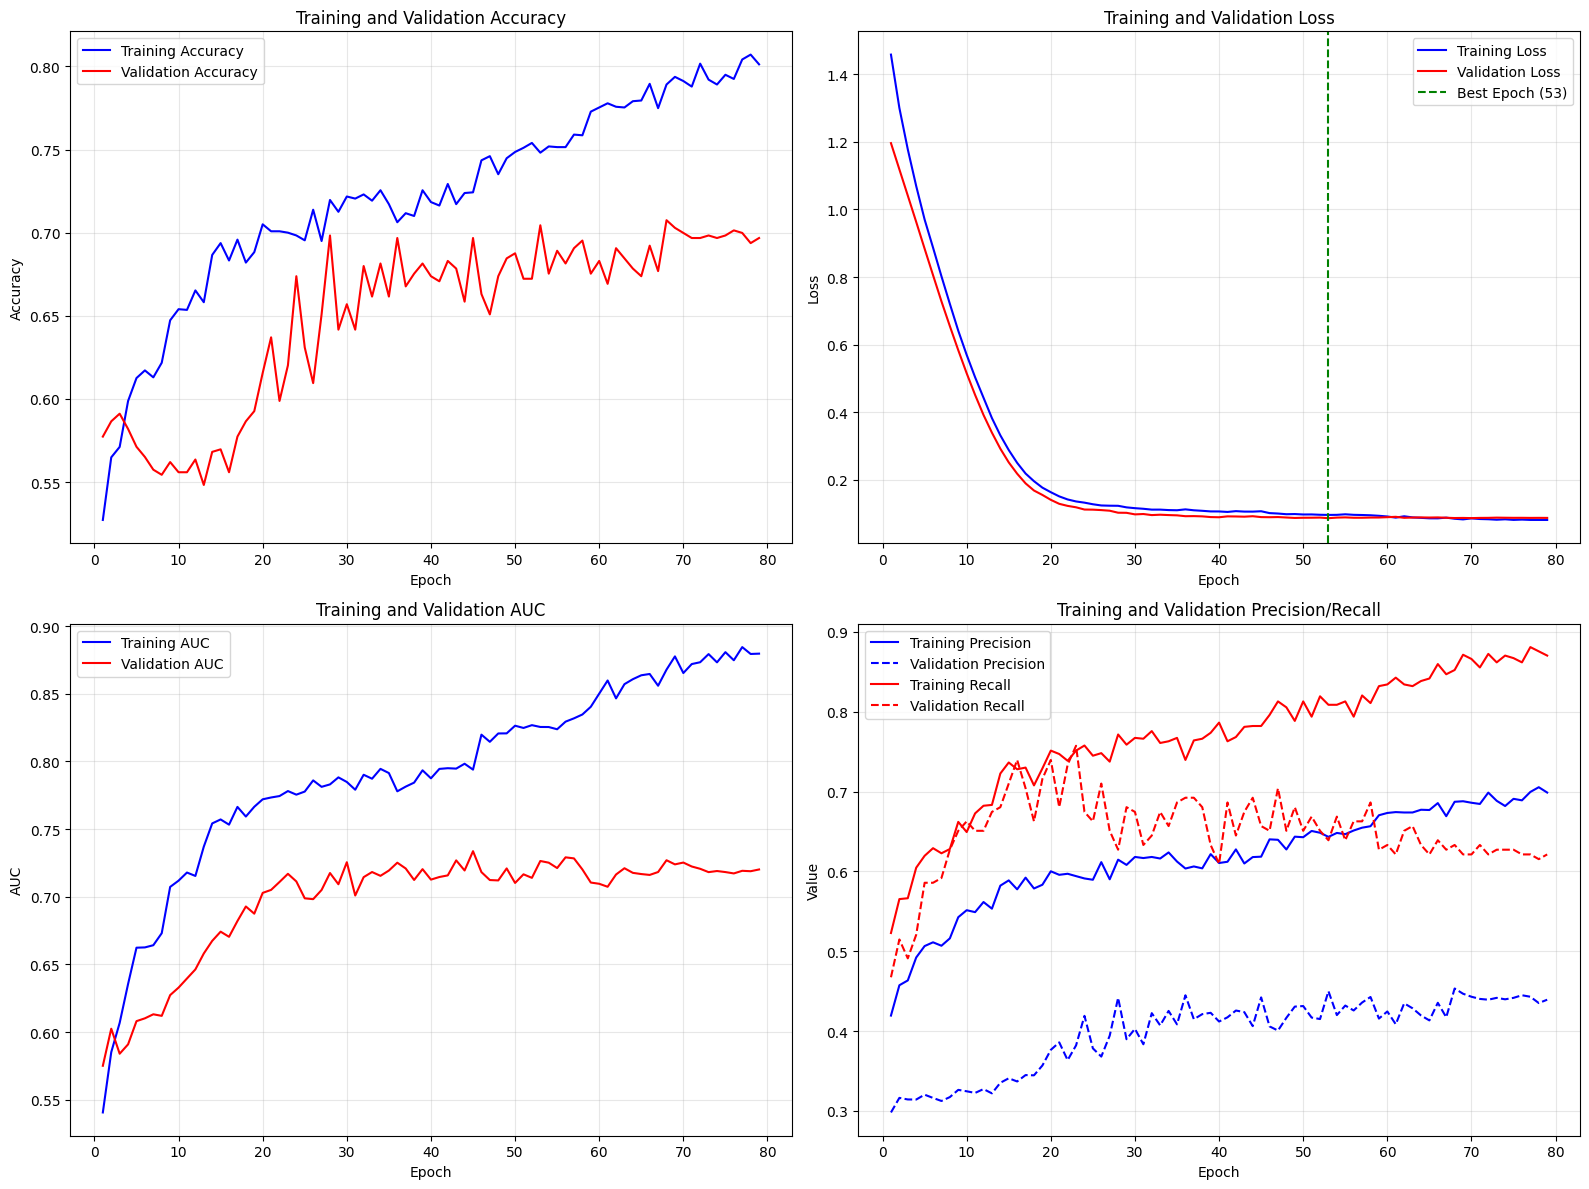

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


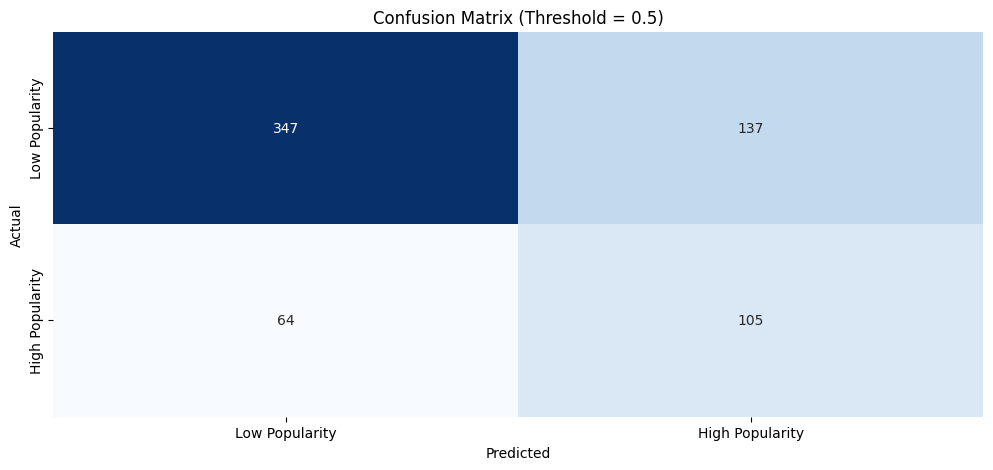


==== Performance Metrics ====
Standard Threshold (0.5):
- Accuracy: 0.6922
- Precision: 0.4339
- Recall: 0.6213
- F1 Score: 0.5109
- AUC: 0.7316

Adjusted Threshold (0.3):
- Accuracy: 0.3446
- Precision: 0.2794
- Recall: 0.9704
- F1 Score: 0.4339
- AUC: 0.7316


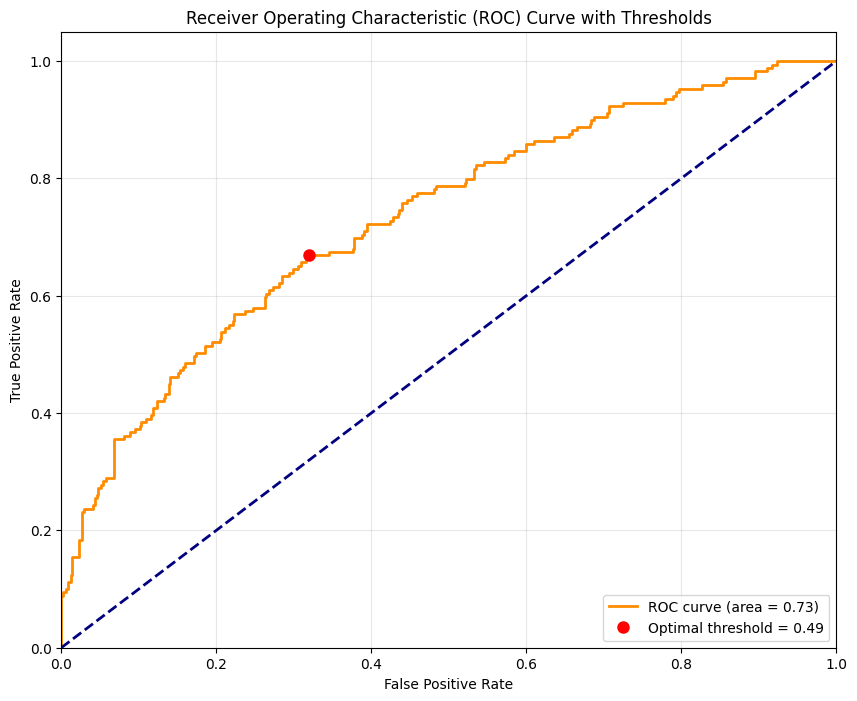

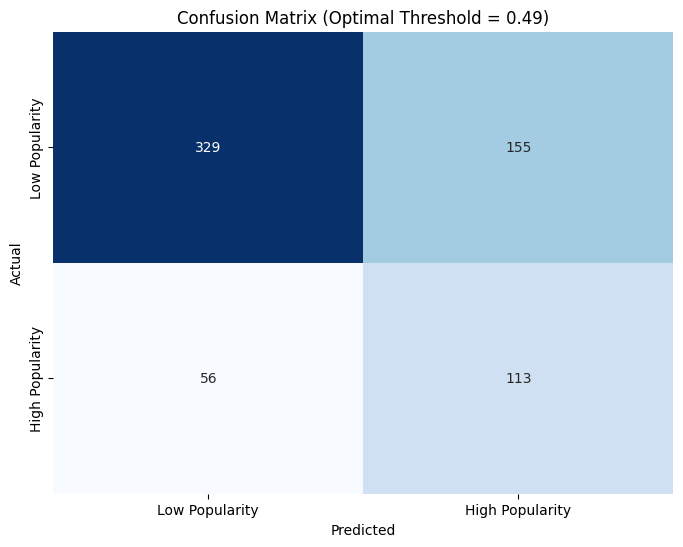


Optimal Threshold (0.4874):
- Accuracy: 0.6769
- Precision: 0.4216
- Recall: 0.6686
- F1 Score: 0.5172
- AUC: 0.7316

FINAL MODEL REPORT AND RECOMMENDATIONS

Class Imbalance Handling:
- Original class distribution: [2417  845] (25.9% positive class)
- SMOTE applied to generate synthetic minority samples
- After SMOTE training class distribution: [1449  941]
- Loss function: Focal Loss (gamma=2, alpha=0.6)
- Optimal classification threshold: 0.4874

Model Performance:
- Test AUC: 0.7316
- Test Accuracy: 0.6769
- Test Precision: 0.4216
- Test Recall: 0.6686
- Test F1 Score: 0.5172


In [68]:

# target - top 25% popularity
y_targ = df.popularity.values
cutoff = 65
y_clf = (y_targ >= cutoff).astype(int)
print(f"Class distribution - Overall: {np.bincount(y_clf)}")
print(f"Class imbalance ratio: 1:{np.bincount(y_clf)[0]/np.bincount(y_clf)[1]:.2f}")

# Calculate class weights based on the imbalance
n_samples = len(y_clf)
n_classes = len(np.unique(y_clf))
class_counts = np.bincount(y_clf)
class_weights = {i: (n_samples / (n_classes * count)) for i, count in enumerate(class_counts)}
print(f"Calculated class weights: {class_weights}")
X = df.drop(columns=['popularity']).values

# Set a lower threshold for prediction
threshold = 0.3 

# train/val/test split
X_train_val, X_test, y_train_val_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)
X_train, X_val, y_train_clf, y_val_clf = train_test_split(
    X_train_val, y_train_val_clf, test_size=0.25, random_state=42, stratify=y_train_val_clf)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Training set: {X_train.shape}, Positive class: {sum(y_train_clf)}/{len(y_train_clf)} ({sum(y_train_clf)/len(y_train_clf)*100:.1f}%)")
print(f"Validation set: {X_val.shape}, Positive class: {sum(y_val_clf)}/{len(y_val_clf)} ({sum(y_val_clf)/len(y_val_clf)*100:.1f}%)")
print(f"Test set: {X_test.shape}, Positive class: {sum(y_test_clf)}/{len(y_test_clf)} ({sum(y_test_clf)/len(y_test_clf)*100:.1f}%)")

# Apply SMOTE for imbalance
print("\n==== Applying SMOTE ====")
print(f"Before SMOTE - Training class distribution: {np.bincount(y_train_clf)}")
print(f"Before SMOTE - Training class ratio: 1:{np.bincount(y_train_clf)[0]/np.bincount(y_train_clf)[1]:.2f}")

smote = SMOTE(random_state=42, sampling_strategy=0.65)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_clf)

# New class distribution
print(f"After SMOTE - Training class distribution: {np.bincount(y_train_smote)}")
print(f"After SMOTE - Training class ratio: 1:{np.bincount(y_train_smote)[0]/np.bincount(y_train_smote)[1]:.2f}")
print(f"Original training set shape: {X_train.shape}, New training set shape: {X_train_smote.shape}")

# Update training data
X_train = X_train_smote
y_train_clf = y_train_smote

# feature selection - random forest
print("\n==== Feature Selection ====")
print("Performing feature selection to reduce dimensionality...")

selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'), threshold="median")

# Fit and transform the training data
selector.fit(X_train, y_train_clf)
X_train_selected = selector.transform(X_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

# Get selected feature indices and names
selected_features_idx = selector.get_support(indices=True)
feature_names = df.drop(columns=['popularity']).columns.tolist()
selected_feature_names = [feature_names[i] for i in selected_features_idx]

print(f"Selected {len(selected_feature_names)} out of {len(feature_names)} features")
print("Selected features:", selected_feature_names[:10], "..." if len(selected_feature_names) > 10 else "")
input_shape = X_train_selected.shape[1]
print(f"New input shape: {input_shape}")


# Build ANN Classification

clf_model = models.Sequential([
    # Input layer
    layers.Input(shape=(input_shape,)),

    # First layer
    layers.Dense(112, activation='relu', 
                 kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5), 

    #Second layer
    layers.Dense(64, activation='relu', 
                 kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5), 

    # Output layer
    layers.Dense(1, activation='sigmoid')])

# Compile model 

# focal loss to address class imbalance
def focal_loss(gamma=3, alpha=0.5):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(tf.clip_by_value(pt_1, 1e-8, 1.0))) - \
               tf.reduce_mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(tf.clip_by_value(1. - pt_0, 1e-8, 1.0)))
    return focal_loss_fixed

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
clf_model.compile(
    optimizer=optimizer,
    # Use focal loss with alpha > 0.5 to give more importance to minority class
    # Can use smaller alpha now that we've applied SMOTE
    loss=focal_loss(gamma=2, alpha=0.6),
    metrics=[
        'accuracy', 
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()])

# callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,  # Increased patience for SMOTE dataset
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001
)

# Reduce learning rate when plateauing
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1)

# Custom callback to monitor for overfitting with SMOTE
class SMOTEOverfittingMonitor(callbacks.Callback):
    def __init__(self, threshold=0.2, patience=3):
        super().__init__()
        self.threshold = threshold
        self.patience = patience
        self.gap_history = []
        self.wait = 0
    
    def on_epoch_end(self, epoch, logs=None):
        acc_gap = logs.get('accuracy') - logs.get('val_accuracy')
        self.gap_history.append(acc_gap)
        
        print(f"\nEpoch {epoch+1}: Train-Val accuracy gap: {acc_gap:.4f}")
        
        # gap shouldn't be too large
        if acc_gap > self.threshold:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nStopping: Accuracy gap > {self.threshold:.2f} for {self.patience} epochs")
                self.model.stop_training = True
        else:
            self.wait = 0

# Add overfitting monitor
gap_monitor = SMOTEOverfittingMonitor(threshold=0.2, patience=3)

# Train model - with SMOTE we can use milder class weights
history = clf_model.fit(
    X_train_selected, y_train_clf,
    validation_data=(X_val_selected, y_val_clf),
    epochs=120,
    batch_size=32, 
    callbacks=[early_stopping, reduce_lr, gap_monitor],
    class_weight={0: 1.0, 1: 1.7}, 
    verbose=1)

# Evaluate model on test set
print("\n==== Model Evaluation ====")
test_results = clf_model.evaluate(X_test_selected, y_test_clf, verbose=1)
metric_names = ['Loss', 'Accuracy', 'AUC', 'Precision', 'Recall']

for name, value in zip(metric_names, test_results):
    print(f"Test {name}: {value:.4f}")

# Plot history 
def plot_training_history(history):
    plt.figure(figsize=(16, 12))
    
    # Plot accuracy
    plt.subplot(2, 2, 1)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)
    
    # Plot main metrics
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot loss 
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
    
    # Calculate ideal stopping point based on validation loss
    best_epoch = np.argmin(history.history['val_loss']) + 1
    plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Check which metric names are available
    auc_keys = [key for key in history.history.keys() if 'auc' in key.lower()]
    val_auc_keys = [key for key in history.history.keys() if 'val' in key.lower() and 'auc' in key.lower()]

    # Plot AUC
    plt.subplot(2, 2, 3)
    if auc_keys and val_auc_keys:
        plt.plot(epochs, history.history[auc_keys[0]], 'b-', label='Training AUC')
        plt.plot(epochs, history.history[val_auc_keys[0]], 'r-', label='Validation AUC')
        plt.title('Training and Validation AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()
    else:
        plt.title('AUC metrics not available')
    plt.grid(True, alpha=0.3)
    
    # Plot Precision and Recall - check which metrics are available
    plt.subplot(2, 2, 4)
    precision_keys = [key for key in history.history.keys() if 'precision' in key.lower() and not 'val' in key.lower()]
    val_precision_keys = [key for key in history.history.keys() if 'precision' in key.lower() and 'val' in key.lower()]
    recall_keys = [key for key in history.history.keys() if 'recall' in key.lower() and not 'val' in key.lower()]
    val_recall_keys = [key for key in history.history.keys() if 'recall' in key.lower() and 'val' in key.lower()]
    
    if precision_keys and val_precision_keys:
        plt.plot(epochs, history.history[precision_keys[0]], 'b-', label='Training Precision')
        plt.plot(epochs, history.history[val_precision_keys[0]], 'b--', label='Validation Precision')
    if recall_keys and val_recall_keys:
        plt.plot(epochs, history.history[recall_keys[0]], 'r-', label='Training Recall')
        plt.plot(epochs, history.history[val_recall_keys[0]], 'r--', label='Validation Recall')
    plt.title('Training and Validation Precision/Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history_with_smote.png')
    plt.show()

    return best_epoch

best_epoch = plot_training_history(history)

# Confusion Matrix - predict on test set
y_pred_proba = clf_model.predict(X_test_selected).ravel()

# Use standard threshold (0.5)
y_pred_standard = (y_pred_proba >= 0.5).astype(int)
# Use a lower threshold to favor the minority class
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)  # Using threshold defined earlier (0.3)

# Plot 
cm_standard = confusion_matrix(y_test_clf, y_pred_standard)
plt.figure(figsize=(12, 5))
sns.heatmap(cm_standard, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Popularity', 'High Popularity'],
            yticklabels=['Low Popularity', 'High Popularity'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = 0.5)')
plt.show()

# Calculate metrics for both thresholds
metrics_standard = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_standard),
    'Precision': precision_score(y_test_clf, y_pred_standard, zero_division=0),
    'Recall': recall_score(y_test_clf, y_pred_standard, zero_division=0),
    'F1 Score': f1_score(y_test_clf, y_pred_standard, zero_division=0),
    'AUC': roc_auc_score(y_test_clf, y_pred_proba)}

metrics_adjusted = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_adjusted),
    'Precision': precision_score(y_test_clf, y_pred_adjusted, zero_division=0),
    'Recall': recall_score(y_test_clf, y_pred_adjusted, zero_division=0),
    'F1 Score': f1_score(y_test_clf, y_pred_adjusted, zero_division=0),
    'AUC': roc_auc_score(y_test_clf, y_pred_proba)}

print("\n==== Performance Metrics ====")
print(f"Standard Threshold (0.5):")
for metric, value in metrics_standard.items():
    print(f"- {metric}: {value:.4f}")

print(f"\nAdjusted Threshold ({threshold}):")
for metric, value in metrics_adjusted.items():
    print(f"- {metric}: {value:.4f}")

# Plot ROC curve 
fpr, tpr, thresholds = roc_curve(y_test_clf, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold
# Youden's J statistic: J = Sensitivity + Specificity - 1 = tpr + (1-fpr) - 1 = tpr - fpr
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_point = (fpr[optimal_idx], tpr[optimal_idx])

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.plot(optimal_point[0], optimal_point[1], 'ro', markersize=8, 
         label=f'Optimal threshold = {optimal_threshold:.2f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with Thresholds')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.show()


# Recalculate predictions with optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(y_test_clf, y_pred_optimal)

# Plot optimal threshold confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Popularity', 'High Popularity'],
            yticklabels=['Low Popularity', 'High Popularity'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Optimal Threshold = {optimal_threshold:.2f})')
plt.savefig('optimal_confusion_matrix_with_smote.png')
plt.show()

# Calculate metrics for optimal threshold
metrics_optimal = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_optimal),
    'Precision': precision_score(y_test_clf, y_pred_optimal, zero_division=0),
    'Recall': recall_score(y_test_clf, y_pred_optimal, zero_division=0),
    'F1 Score': f1_score(y_test_clf, y_pred_optimal, zero_division=0),
    'AUC': roc_auc_score(y_test_clf, y_pred_proba)
}

print(f"\nOptimal Threshold ({optimal_threshold:.4f}):")
for metric, value in metrics_optimal.items():
    print(f"- {metric}: {value:.4f}")


# 17. Print final summary and recommendations
print("\n" + "="*50)
print("FINAL MODEL REPORT AND RECOMMENDATIONS")
print("="*50)

print("\nClass Imbalance Handling:")
print(f"- Original class distribution: {np.bincount(y_clf)} ({np.bincount(y_clf)[1]/len(y_clf)*100:.1f}% positive class)")
print(f"- SMOTE applied to generate synthetic minority samples")
print(f"- After SMOTE training class distribution: {np.bincount(y_train_clf)}")
print(f"- Loss function: Focal Loss (gamma=2, alpha=0.6)")
print(f"- Optimal classification threshold: {optimal_threshold:.4f}")

print("\nModel Performance:")
print(f"- Test AUC: {metrics_optimal['AUC']:.4f}")
print(f"- Test Accuracy: {metrics_optimal['Accuracy']:.4f}")
print(f"- Test Precision: {metrics_optimal['Precision']:.4f}")
print(f"- Test Recall: {metrics_optimal['Recall']:.4f}")
print(f"- Test F1 Score: {metrics_optimal['F1 Score']:.4f}")



Class distribution - Overall: [2417  845]
Class imbalance ratio: 1:2.86
Calculated class weights: {0: 0.6748034753827058, 1: 1.9301775147928995}
Training set: (1956, 98), Positive class: 507/1956 (25.9%)
Validation set: (653, 98), Positive class: 169/653 (25.9%)
Test set: (653, 98), Positive class: 169/653 (25.9%)

==== Applying SMOTE ====
Before SMOTE - Training class distribution: [1449  507]
Before SMOTE - Training class ratio: 1:2.86
After SMOTE - Training class distribution: [1449  941]
After SMOTE - Training class ratio: 1:1.54
Original training set shape: (1956, 98), New training set shape: (2390, 98)

==== Feature Selection ====
Performing feature selection to reduce dimensionality...


/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selected 49 out of 98 features
Selected features: ['total_tracks', 'face', 'skin_percentage', 'followers', 'count_person', 'max_confidence_person', 'total_object_count', 'avg_detection_confidence', 'avg_brightness', 'brightness_std'] ...
New input shape: 49


/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/120
69/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5198 - auc_28: 0.5537 - loss: 1.6635 - precision_28: 0.4318 - recall_28: 0.6740
Epoch 1: Train-Val accuracy gap: -0.1510
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5195 - auc_28: 0.5530 - loss: 1.6571 - precision_28: 0.4309 - recall_28: 0.6687 - val_accuracy: 0.6677 - val_auc_28: 0.6166 - val_loss: 1.3815 - val_precision_28: 0.3462 - val_recall_28: 0.3195 - learning_rate: 0.0010
Epoch 2/120
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5278 - auc_28: 0.5354 - loss: 1.4212 - precision_28: 0.4252 - recall_28: 0.5484
Epoch 2: Train-Val accuracy gap: -0.1572
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5282 - auc_28: 0.5362 - loss: 1.4189 - precision_28: 0.4255 - recall_28: 0.5489 - val_accuracy: 0.6953 - val_auc_28: 0.6188 - val_loss: 1.1860 - val_precision_28: 0.3661 - val_recall_28: 0.2426 - learning_rate: 0.0010
Epoch 3/120
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5603 - auc_28: 0.574

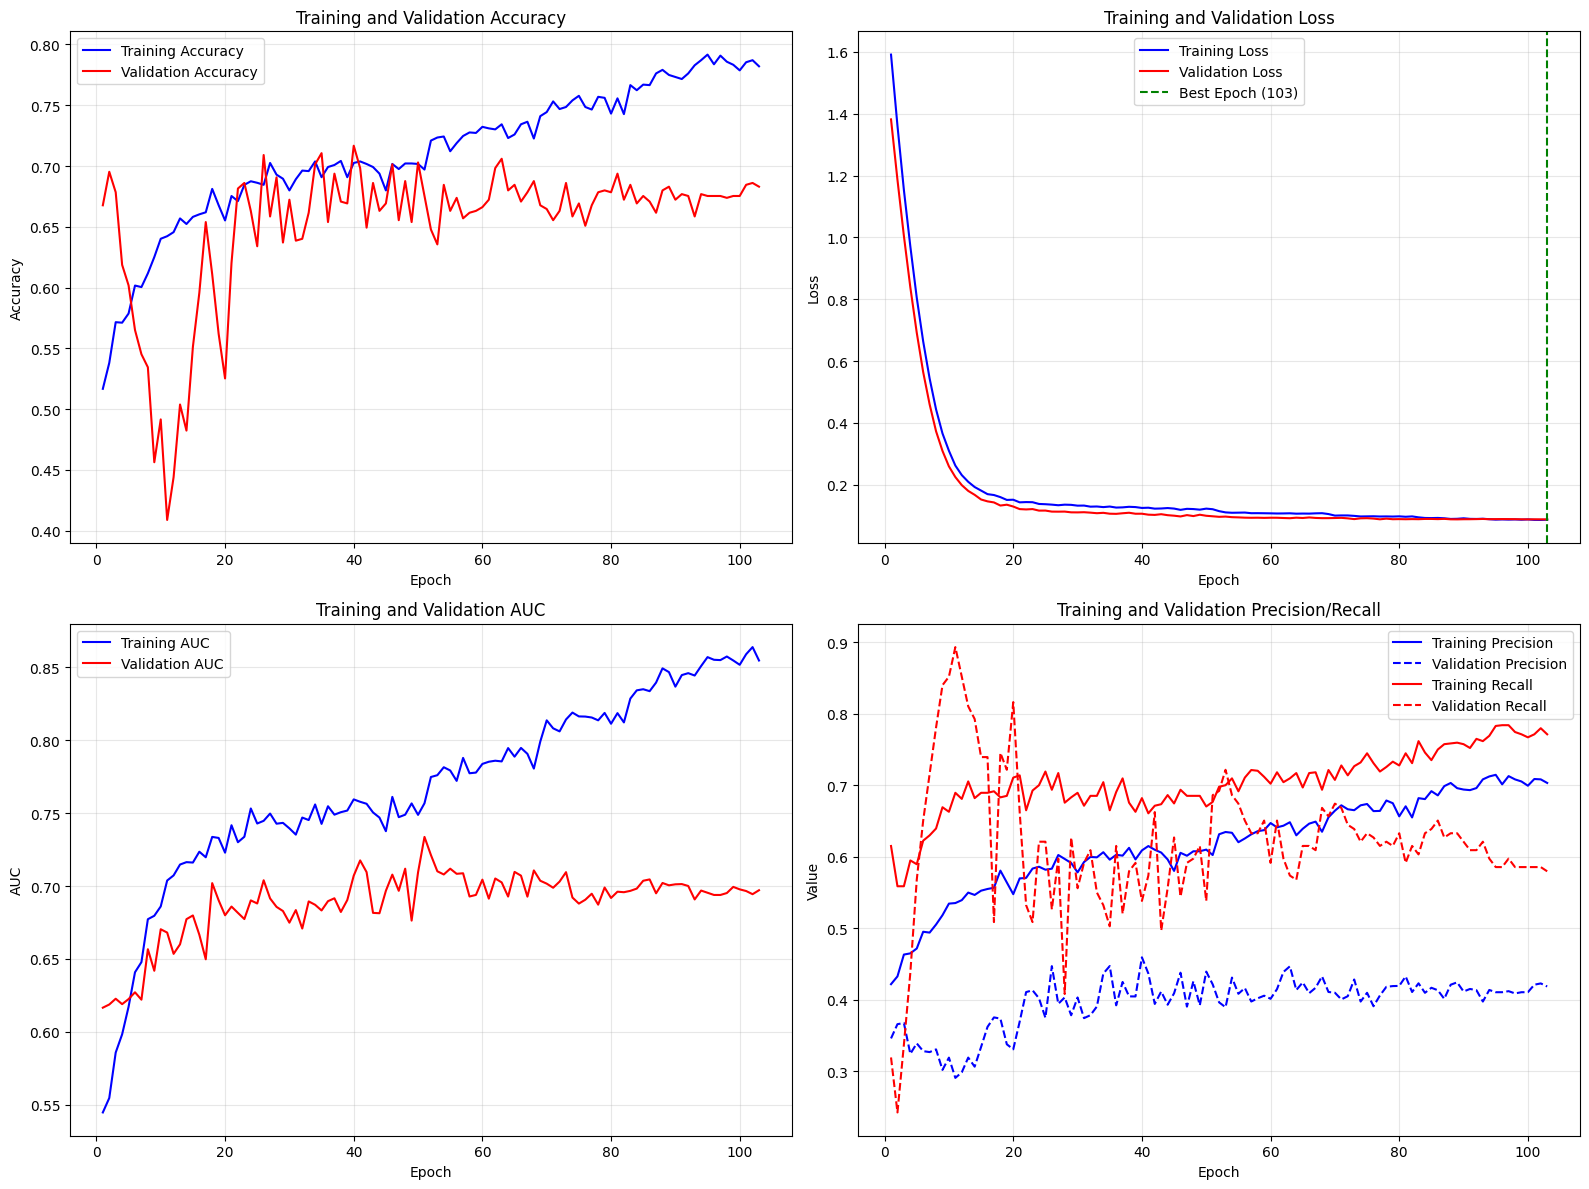

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


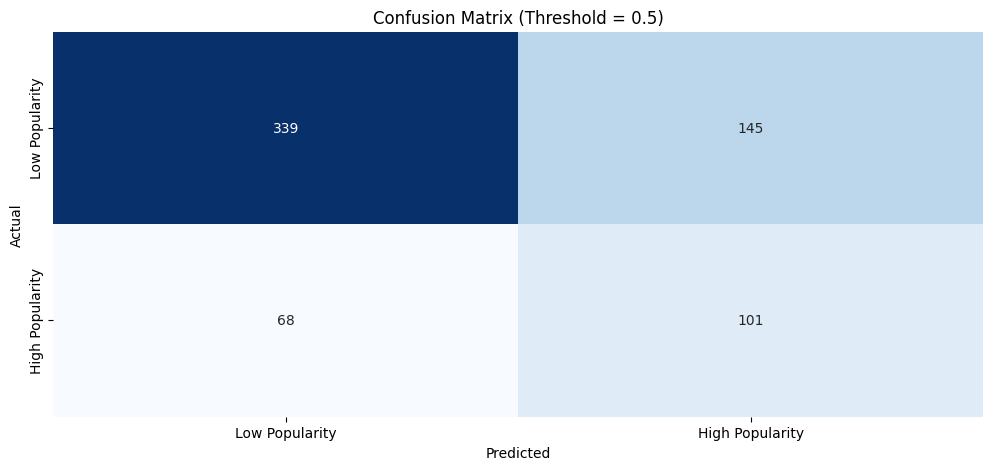


==== Performance Metrics ====
Standard Threshold (0.5):
- Accuracy: 0.6738
- Precision: 0.4106
- Recall: 0.5976
- F1 Score: 0.4867
- AUC: 0.7252

Adjusted Threshold (0.3):
- Accuracy: 0.2711
- Precision: 0.2620
- Recall: 1.0000
- F1 Score: 0.4152
- AUC: 0.7252


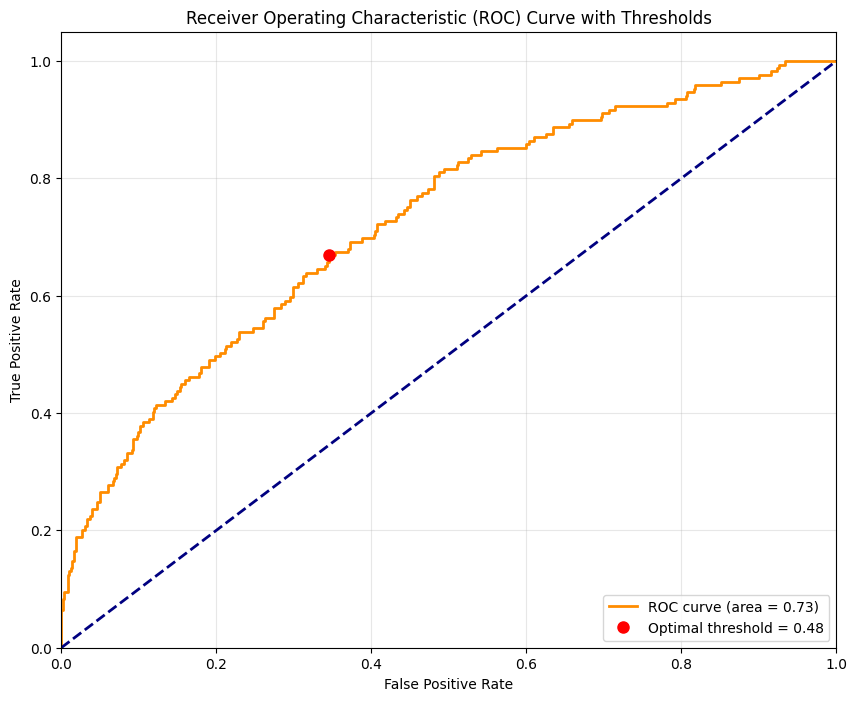

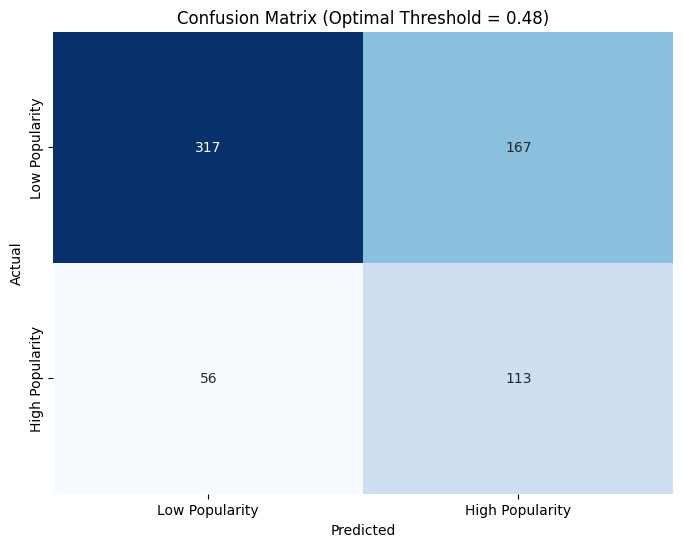


Optimal Threshold (0.4758):
- Accuracy: 0.6585
- Precision: 0.4036
- Recall: 0.6686
- F1 Score: 0.5033
- AUC: 0.7252

FINAL MODEL REPORT AND RECOMMENDATIONS

Class Imbalance Handling:
- Original class distribution: [2417  845] (25.9% positive class)
- SMOTE applied to generate synthetic minority samples
- After SMOTE training class distribution: [1449  941]
- Loss function: Focal Loss (gamma=2, alpha=0.6)
- Optimal classification threshold: 0.4758

Model Performance:
- Test AUC: 0.7252
- Test Accuracy: 0.6585
- Test Precision: 0.4036
- Test Recall: 0.6686
- Test F1 Score: 0.5033


In [72]:

# target - top 25% popularity
y_targ = df.popularity.values
cutoff = 65
y_clf = (y_targ >= cutoff).astype(int)
print(f"Class distribution - Overall: {np.bincount(y_clf)}")
print(f"Class imbalance ratio: 1:{np.bincount(y_clf)[0]/np.bincount(y_clf)[1]:.2f}")

# Calculate class weights based on the imbalance
n_samples = len(y_clf)
n_classes = len(np.unique(y_clf))
class_counts = np.bincount(y_clf)
class_weights = {i: (n_samples / (n_classes * count)) for i, count in enumerate(class_counts)}
print(f"Calculated class weights: {class_weights}")
X = df.drop(columns=['popularity']).values

# Set a lower threshold for prediction
threshold = 0.3 

# train/val/test split
X_train_val, X_test, y_train_val_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)
X_train, X_val, y_train_clf, y_val_clf = train_test_split(
    X_train_val, y_train_val_clf, test_size=0.25, random_state=42, stratify=y_train_val_clf)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Training set: {X_train.shape}, Positive class: {sum(y_train_clf)}/{len(y_train_clf)} ({sum(y_train_clf)/len(y_train_clf)*100:.1f}%)")
print(f"Validation set: {X_val.shape}, Positive class: {sum(y_val_clf)}/{len(y_val_clf)} ({sum(y_val_clf)/len(y_val_clf)*100:.1f}%)")
print(f"Test set: {X_test.shape}, Positive class: {sum(y_test_clf)}/{len(y_test_clf)} ({sum(y_test_clf)/len(y_test_clf)*100:.1f}%)")

# Apply SMOTE for imbalance
print("\n==== Applying SMOTE ====")
print(f"Before SMOTE - Training class distribution: {np.bincount(y_train_clf)}")
print(f"Before SMOTE - Training class ratio: 1:{np.bincount(y_train_clf)[0]/np.bincount(y_train_clf)[1]:.2f}")

smote = SMOTE(random_state=42, sampling_strategy=0.65)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_clf)

# New class distribution
print(f"After SMOTE - Training class distribution: {np.bincount(y_train_smote)}")
print(f"After SMOTE - Training class ratio: 1:{np.bincount(y_train_smote)[0]/np.bincount(y_train_smote)[1]:.2f}")
print(f"Original training set shape: {X_train.shape}, New training set shape: {X_train_smote.shape}")

# Update training data
X_train = X_train_smote
y_train_clf = y_train_smote

# feature selection - random forest
print("\n==== Feature Selection ====")
print("Performing feature selection to reduce dimensionality...")

selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'), threshold="median")

# Fit and transform the training data
selector.fit(X_train, y_train_clf)
X_train_selected = selector.transform(X_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

# Get selected feature indices and names
selected_features_idx = selector.get_support(indices=True)
feature_names = df.drop(columns=['popularity']).columns.tolist()
selected_feature_names = [feature_names[i] for i in selected_features_idx]

print(f"Selected {len(selected_feature_names)} out of {len(feature_names)} features")
print("Selected features:", selected_feature_names[:10], "..." if len(selected_feature_names) > 10 else "")
input_shape = X_train_selected.shape[1]
print(f"New input shape: {input_shape}")


# Build ANN Classification

clf_model = models.Sequential([
    # Input layer
    layers.Input(shape=(input_shape,)),
    
    # First layer - reduced size, LeakyReLU
    layers.Dense(96, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.4),
    
    # Second layer
    layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.4),
    
    # New layer
    layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.3),
    
    # Output layer
    layers.Dense(1, activation='sigmoid')
])

# Compile model 

# focal loss to address class imbalance
def focal_loss(gamma=3, alpha=0.5):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(tf.clip_by_value(pt_1, 1e-8, 1.0))) - \
               tf.reduce_mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(tf.clip_by_value(1. - pt_0, 1e-8, 1.0)))
    return focal_loss_fixed

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    weight_decay=0.01
)
clf_model.compile(
    optimizer=optimizer,
    # Use focal loss with alpha > 0.5 to give more importance to minority class
    # Can use smaller alpha now that we've applied SMOTE
    loss=focal_loss(gamma=2, alpha=0.6),
    metrics=[
        'accuracy', 
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()])

# callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,  # Increased patience for SMOTE dataset
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001
)

# Reduce learning rate when plateauing
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1)

# Custom callback to monitor for overfitting with SMOTE
class SMOTEOverfittingMonitor(callbacks.Callback):
    def __init__(self, threshold=0.2, patience=3):
        super().__init__()
        self.threshold = threshold
        self.patience = patience
        self.gap_history = []
        self.wait = 0
    
    def on_epoch_end(self, epoch, logs=None):
        acc_gap = logs.get('accuracy') - logs.get('val_accuracy')
        self.gap_history.append(acc_gap)
        
        print(f"\nEpoch {epoch+1}: Train-Val accuracy gap: {acc_gap:.4f}")
        
        # gap shouldn't be too large
        if acc_gap > self.threshold:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nStopping: Accuracy gap > {self.threshold:.2f} for {self.patience} epochs")
                self.model.stop_training = True
        else:
            self.wait = 0

# Add overfitting monitor
gap_monitor = SMOTEOverfittingMonitor(threshold=0.2, patience=3)

# Train model - with SMOTE we can use milder class weights
history = clf_model.fit(
    X_train_selected, y_train_clf,
    validation_data=(X_val_selected, y_val_clf),
    epochs=120,
    batch_size=32, 
    callbacks=[early_stopping, reduce_lr, gap_monitor],
    class_weight={0: 1.0, 1: 1.7}, 
    verbose=1)

# Evaluate model on test set
print("\n==== Model Evaluation ====")
test_results = clf_model.evaluate(X_test_selected, y_test_clf, verbose=1)
metric_names = ['Loss', 'Accuracy', 'AUC', 'Precision', 'Recall']

for name, value in zip(metric_names, test_results):
    print(f"Test {name}: {value:.4f}")

# Plot history 
def plot_training_history(history):
    plt.figure(figsize=(16, 12))
    
    # Plot accuracy
    plt.subplot(2, 2, 1)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)
    
    # Plot main metrics
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot loss 
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
    
    # Calculate ideal stopping point based on validation loss
    best_epoch = np.argmin(history.history['val_loss']) + 1
    plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Check which metric names are available
    auc_keys = [key for key in history.history.keys() if 'auc' in key.lower()]
    val_auc_keys = [key for key in history.history.keys() if 'val' in key.lower() and 'auc' in key.lower()]

    # Plot AUC
    plt.subplot(2, 2, 3)
    if auc_keys and val_auc_keys:
        plt.plot(epochs, history.history[auc_keys[0]], 'b-', label='Training AUC')
        plt.plot(epochs, history.history[val_auc_keys[0]], 'r-', label='Validation AUC')
        plt.title('Training and Validation AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()
    else:
        plt.title('AUC metrics not available')
    plt.grid(True, alpha=0.3)
    
    # Plot Precision and Recall - check which metrics are available
    plt.subplot(2, 2, 4)
    precision_keys = [key for key in history.history.keys() if 'precision' in key.lower() and not 'val' in key.lower()]
    val_precision_keys = [key for key in history.history.keys() if 'precision' in key.lower() and 'val' in key.lower()]
    recall_keys = [key for key in history.history.keys() if 'recall' in key.lower() and not 'val' in key.lower()]
    val_recall_keys = [key for key in history.history.keys() if 'recall' in key.lower() and 'val' in key.lower()]
    
    if precision_keys and val_precision_keys:
        plt.plot(epochs, history.history[precision_keys[0]], 'b-', label='Training Precision')
        plt.plot(epochs, history.history[val_precision_keys[0]], 'b--', label='Validation Precision')
    if recall_keys and val_recall_keys:
        plt.plot(epochs, history.history[recall_keys[0]], 'r-', label='Training Recall')
        plt.plot(epochs, history.history[val_recall_keys[0]], 'r--', label='Validation Recall')
    plt.title('Training and Validation Precision/Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history_with_smote.png')
    plt.show()

    return best_epoch

best_epoch = plot_training_history(history)

# Confusion Matrix - predict on test set
y_pred_proba = clf_model.predict(X_test_selected).ravel()

# Use standard threshold (0.5)
y_pred_standard = (y_pred_proba >= 0.5).astype(int)
# Use a lower threshold to favor the minority class
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)  # Using threshold defined earlier (0.3)

# Plot 
cm_standard = confusion_matrix(y_test_clf, y_pred_standard)
plt.figure(figsize=(12, 5))
sns.heatmap(cm_standard, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Popularity', 'High Popularity'],
            yticklabels=['Low Popularity', 'High Popularity'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = 0.5)')
plt.show()

# Calculate metrics for both thresholds
metrics_standard = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_standard),
    'Precision': precision_score(y_test_clf, y_pred_standard, zero_division=0),
    'Recall': recall_score(y_test_clf, y_pred_standard, zero_division=0),
    'F1 Score': f1_score(y_test_clf, y_pred_standard, zero_division=0),
    'AUC': roc_auc_score(y_test_clf, y_pred_proba)}

metrics_adjusted = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_adjusted),
    'Precision': precision_score(y_test_clf, y_pred_adjusted, zero_division=0),
    'Recall': recall_score(y_test_clf, y_pred_adjusted, zero_division=0),
    'F1 Score': f1_score(y_test_clf, y_pred_adjusted, zero_division=0),
    'AUC': roc_auc_score(y_test_clf, y_pred_proba)}

print("\n==== Performance Metrics ====")
print(f"Standard Threshold (0.5):")
for metric, value in metrics_standard.items():
    print(f"- {metric}: {value:.4f}")

print(f"\nAdjusted Threshold ({threshold}):")
for metric, value in metrics_adjusted.items():
    print(f"- {metric}: {value:.4f}")

# Plot ROC curve 
fpr, tpr, thresholds = roc_curve(y_test_clf, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold
# Youden's J statistic: J = Sensitivity + Specificity - 1 = tpr + (1-fpr) - 1 = tpr - fpr
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_point = (fpr[optimal_idx], tpr[optimal_idx])

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.plot(optimal_point[0], optimal_point[1], 'ro', markersize=8, 
         label=f'Optimal threshold = {optimal_threshold:.2f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with Thresholds')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.show()


# Recalculate predictions with optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(y_test_clf, y_pred_optimal)

# Plot optimal threshold confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Popularity', 'High Popularity'],
            yticklabels=['Low Popularity', 'High Popularity'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Optimal Threshold = {optimal_threshold:.2f})')
plt.savefig('optimal_confusion_matrix_with_smote.png')
plt.show()

# Calculate metrics for optimal threshold
metrics_optimal = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_optimal),
    'Precision': precision_score(y_test_clf, y_pred_optimal, zero_division=0),
    'Recall': recall_score(y_test_clf, y_pred_optimal, zero_division=0),
    'F1 Score': f1_score(y_test_clf, y_pred_optimal, zero_division=0),
    'AUC': roc_auc_score(y_test_clf, y_pred_proba)
}

print(f"\nOptimal Threshold ({optimal_threshold:.4f}):")
for metric, value in metrics_optimal.items():
    print(f"- {metric}: {value:.4f}")


# 17. Print final summary and recommendations
print("\n" + "="*50)
print("FINAL MODEL REPORT AND RECOMMENDATIONS")
print("="*50)

print("\nClass Imbalance Handling:")
print(f"- Original class distribution: {np.bincount(y_clf)} ({np.bincount(y_clf)[1]/len(y_clf)*100:.1f}% positive class)")
print(f"- SMOTE applied to generate synthetic minority samples")
print(f"- After SMOTE training class distribution: {np.bincount(y_train_clf)}")
print(f"- Loss function: Focal Loss (gamma=2, alpha=0.6)")
print(f"- Optimal classification threshold: {optimal_threshold:.4f}")

print("\nModel Performance:")
print(f"- Test AUC: {metrics_optimal['AUC']:.4f}")
print(f"- Test Accuracy: {metrics_optimal['Accuracy']:.4f}")
print(f"- Test Precision: {metrics_optimal['Precision']:.4f}")
print(f"- Test Recall: {metrics_optimal['Recall']:.4f}")
print(f"- Test F1 Score: {metrics_optimal['F1 Score']:.4f}")



## Try random forest


In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, 
                            recall_score, f1_score, roc_curve, auc, roc_auc_score)
from imblearn.over_sampling import SMOTE

In [76]:
# target - top 25% popularity
y_targ = df.popularity.values
cutoff = 65
y_clf = (y_targ >= cutoff).astype(int)
print(f"Class distribution - Overall: {np.bincount(y_clf)}")
print(f"Class imbalance ratio: 1:{np.bincount(y_clf)[0]/np.bincount(y_clf)[1]:.2f}")

# Calculate class weights based on the imbalance
n_samples = len(y_clf)
n_classes = len(np.unique(y_clf))
class_counts = np.bincount(y_clf)
class_weights = {i: (n_samples / (n_classes * count)) for i, count in enumerate(class_counts)}
print(f"Calculated class weights: {class_weights}")
X = df.drop(columns=['popularity']).values

# Set a lower threshold for prediction
threshold = 0.3 

# train/val/test split
X_train_val, X_test, y_train_val_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)
X_train, X_val, y_train_clf, y_val_clf = train_test_split(
    X_train_val, y_train_val_clf, test_size=0.25, random_state=42, stratify=y_train_val_clf)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Training set: {X_train.shape}, Positive class: {sum(y_train_clf)}/{len(y_train_clf)} ({sum(y_train_clf)/len(y_train_clf)*100:.1f}%)")
print(f"Validation set: {X_val.shape}, Positive class: {sum(y_val_clf)}/{len(y_val_clf)} ({sum(y_val_clf)/len(y_val_clf)*100:.1f}%)")
print(f"Test set: {X_test.shape}, Positive class: {sum(y_test_clf)}/{len(y_test_clf)} ({sum(y_test_clf)/len(y_test_clf)*100:.1f}%)")

# Apply SMOTE for imbalance
print("\n==== Applying SMOTE ====")
print(f"Before SMOTE - Training class distribution: {np.bincount(y_train_clf)}")
print(f"Before SMOTE - Training class ratio: 1:{np.bincount(y_train_clf)[0]/np.bincount(y_train_clf)[1]:.2f}")

smote = SMOTE(random_state=42, sampling_strategy=0.65)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_clf)

# New class distribution
print(f"After SMOTE - Training class distribution: {np.bincount(y_train_smote)}")
print(f"After SMOTE - Training class ratio: 1:{np.bincount(y_train_smote)[0]/np.bincount(y_train_smote)[1]:.2f}")
print(f"Original training set shape: {X_train.shape}, New training set shape: {X_train_smote.shape}")

# Update training data
X_train = X_train_smote
y_train_clf = y_train_smote

# Store original feature names for later use
feature_names = df.drop(columns=['popularity']).columns.tolist()

# GRADIENT BOOSTING MODEL IMPLEMENTATION
print("\n==== Training Gradient Boosting Model ====")

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid for hyperparameter tuning
# Define a wider parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# Initial model for grid search
gb_init = GradientBoostingClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=gb_init,
    param_grid=param_grid,
    cv=5,
    scoring='f1',  # Using F1 score since we care about both precision and recall
    verbose=1,
    n_jobs=-1  # Use all available cores
)

print("Performing hyperparameter tuning with GridSearchCV...")
grid_search.fit(X_train, y_train_clf)

# Get best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train final model with best parameters
gb_model = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    subsample=best_params['subsample'],
    random_state=42
)

# Train the model
gb_model.fit(X_train, y_train_clf)

# Validation performance
val_pred_proba = gb_model.predict_proba(X_val)[:, 1]
val_pred = (val_pred_proba >= 0.5).astype(int)
val_accuracy = accuracy_score(y_val_clf, val_pred)
val_precision = precision_score(y_val_clf, val_pred)
val_recall = recall_score(y_val_clf, val_pred)
val_f1 = f1_score(y_val_clf, val_pred)
val_auc = roc_auc_score(y_val_clf, val_pred_proba)

print("\n==== Validation Performance ====")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

# Test set evaluation
print("\n==== Model Evaluation on Test Set ====")
y_pred_proba = gb_model.predict_proba(X_test)[:, 1]
y_pred_standard = (y_pred_proba >= 0.5).astype(int)
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)  # Using threshold defined earlier (0.3)

# Calculate metrics for both thresholds
metrics_standard = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_standard),
    'Precision': precision_score(y_test_clf, y_pred_standard, zero_division=0),
    'Recall': recall_score(y_test_clf, y_pred_standard, zero_division=0),
    'F1 Score': f1_score(y_test_clf, y_pred_standard, zero_division=0),
    'AUC': roc_auc_score(y_test_clf, y_pred_proba)
}

metrics_adjusted = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_adjusted),
    'Precision': precision_score(y_test_clf, y_pred_adjusted, zero_division=0),
    'Recall': recall_score(y_test_clf, y_pred_adjusted, zero_division=0),
    'F1 Score': f1_score(y_test_clf, y_pred_adjusted, zero_division=0),
    'AUC': roc_auc_score(y_test_clf, y_pred_proba)
}

print("\n==== Performance Metrics ====")
print(f"Standard Threshold (0.5):")
for metric, value in metrics_standard.items():
    print(f"- {metric}: {value:.4f}")

print(f"\nAdjusted Threshold ({threshold}):")
for metric, value in metrics_adjusted.items():
    print(f"- {metric}: {value:.4f}")

# Plot confusion matrix - standard threshold
cm_standard = confusion_matrix(y_test_clf, y_pred_standard)
plt.figure(figsize=(12, 5))
sns.heatmap(cm_standard, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Popularity', 'High Popularity'],
            yticklabels=['Low Popularity', 'High Popularity'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = 0.5)')
plt.show()

# Plot ROC curve 
fpr, tpr, thresholds = roc_curve(y_test_clf, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold
# Youden's J statistic: J = Sensitivity + Specificity - 1 = tpr + (1-fpr) - 1 = tpr - fpr
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_point = (fpr[optimal_idx], tpr[optimal_idx])

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.plot(optimal_point[0], optimal_point[1], 'ro', markersize=8, 
         label=f'Optimal threshold = {optimal_threshold:.2f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with Thresholds')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.show()

# Recalculate predictions with optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(y_test_clf, y_pred_optimal)

# Plot optimal threshold confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Popularity', 'High Popularity'],
            yticklabels=['Low Popularity', 'High Popularity'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Optimal Threshold = {optimal_threshold:.2f})')
plt.savefig('optimal_confusion_matrix_gradient_boosting.png')
plt.show()

# Calculate metrics for optimal threshold
metrics_optimal = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_optimal),
    'Precision': precision_score(y_test_clf, y_pred_optimal, zero_division=0),
    'Recall': recall_score(y_test_clf, y_pred_optimal, zero_division=0),
    'F1 Score': f1_score(y_test_clf, y_pred_optimal, zero_division=0),
    'AUC': roc_auc_score(y_test_clf, y_pred_proba)
}

print(f"\nOptimal Threshold ({optimal_threshold:.4f}):")
for metric, value in metrics_optimal.items():
    print(f"- {metric}: {value:.4f}")

# FEATURE IMPORTANCE ANALYSIS
print("\n==== Feature Importance Analysis ====")

# Extract feature importances
importances = gb_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(min(20, len(feature_names))):  # Print top 20 features
    print(f"{f+1}. Feature '{feature_names[indices[f]]}' ({importances[indices[f]]:.4f})")

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(min(20, len(feature_names))), 
        importances[indices[:20]],
        align="center")
plt.xticks(range(min(20, len(feature_names))), 
           [feature_names[i] for i in indices[:20]], 
           rotation=90)
plt.xlim([-1, min(20, len(feature_names))])
plt.tight_layout()
plt.savefig('feature_importance_gradient_boosting.png')
plt.show()

# Create a DataFrame for feature importance for easier viewing
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))

# Cumulative Feature Importance
feature_importance_df['Cumulative_Importance'] = feature_importance_df['Importance'].cumsum()
print("\nNumber of features needed for 90% importance:", 
      len(feature_importance_df[feature_importance_df['Cumulative_Importance'] <= 0.9]) + 1)

# Plot cumulative feature importance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(feature_importance_df) + 1), 
         feature_importance_df['Cumulative_Importance'], 
         marker='o', linestyle='-')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Importance Threshold')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('cumulative_feature_importance.png')
plt.show()

# Print final summary
print("\n" + "="*50)
print("FINAL MODEL REPORT AND RECOMMENDATIONS")
print("="*50)

print("\nClass Imbalance Handling:")
print(f"- Original class distribution: {np.bincount(y_clf)} ({np.bincount(y_clf)[1]/len(y_clf)*100:.1f}% positive class)")
print(f"- SMOTE applied to generate synthetic minority samples")
print(f"- After SMOTE training class distribution: {np.bincount(y_train_clf)}")
print(f"- Optimal classification threshold: {optimal_threshold:.4f}")

print("\nModel Performance:")
print(f"- Test AUC: {metrics_optimal['AUC']:.4f}")
print(f"- Test Accuracy: {metrics_optimal['Accuracy']:.4f}")
print(f"- Test Precision: {metrics_optimal['Precision']:.4f}")
print(f"- Test Recall: {metrics_optimal['Recall']:.4f}")
print(f"- Test F1 Score: {metrics_optimal['F1 Score']:.4f}")

print("\nFeature Importance:")
print(f"- Top 3 most influential features: {', '.join(feature_importance_df['Feature'].head(3).tolist())}")
print(f"- Number of features accounting for 90% of importance: {len(feature_importance_df[feature_importance_df['Cumulative_Importance'] <= 0.9]) + 1}")

Class distribution - Overall: [2417  845]
Class imbalance ratio: 1:2.86
Calculated class weights: {0: 0.6748034753827058, 1: 1.9301775147928995}
Training set: (1956, 98), Positive class: 507/1956 (25.9%)
Validation set: (653, 98), Positive class: 169/653 (25.9%)
Test set: (653, 98), Positive class: 169/653 (25.9%)

==== Applying SMOTE ====
Before SMOTE - Training class distribution: [1449  507]
Before SMOTE - Training class ratio: 1:2.86
After SMOTE - Training class distribution: [1449  941]
After SMOTE - Training class ratio: 1:1.54
Original training set shape: (1956, 98), New training set shape: (2390, 98)

==== Training Gradient Boosting Model ====
Performing hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 11520 candidates, totalling 57600 fits


/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
